<a href="https://www.kaggle.com/code/rakesh1248/easyvisa-problem?scriptVersionId=250145153" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
#Will be installing XGBoost first as we will be using this as library in our Python Code
!pip install xgboost


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
from sklearn.ensemble import (BaggingClassifier,RandomForestClassifier,
                              GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier)
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn import metrics
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score

In [5]:


# Replace 'path/to/your/file.csv' with the actual path to your CSV file in Google Drive
file_path = '/kaggle/input/easyvisa/EasyVisa.csv'

try:
    df = pd.read_csv(file_path)
    print("CSV file read successfully!")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

CSV file read successfully!


In [6]:
#Print top 5 data
data = df.head()
print(data)

  case_id continent education_of_employee has_job_experience  \
0  EZYV01      Asia           High School                  N   
1  EZYV02      Asia              Master's                  Y   
2  EZYV03      Asia            Bachelor's                  N   
3  EZYV04      Asia            Bachelor's                  N   
4  EZYV05    Africa              Master's                  Y   

  requires_job_training  no_of_employees  yr_of_estab region_of_employment  \
0                     N            14513         2007                 West   
1                     N             2412         2002            Northeast   
2                     Y            44444         2008                 West   
3                     N               98         1897                 West   
4                     N             1082         2005                South   

   prevailing_wage unit_of_wage full_time_position case_status  
0         592.2029         Hour                  Y      Denied  
1       83425.65

In [7]:
#Print the information on datatypes and structure
data.info()
data.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                5 non-null      object 
 1   continent              5 non-null      object 
 2   education_of_employee  5 non-null      object 
 3   has_job_experience     5 non-null      object 
 4   requires_job_training  5 non-null      object 
 5   no_of_employees        5 non-null      int64  
 6   yr_of_estab            5 non-null      int64  
 7   region_of_employment   5 non-null      object 
 8   prevailing_wage        5 non-null      float64
 9   unit_of_wage           5 non-null      object 
 10  full_time_position     5 non-null      object 
 11  case_status            5 non-null      object 
dtypes: float64(1), int64(2), object(9)
memory usage: 612.0+ bytes


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
case_id,5,5,EZYV01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
continent,5,2,Asia,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_of_employee,5,3,Master's,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_job_experience,5,2,N,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
requires_job_training,5,2,N,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_of_employees,5.0,NaN,NaN,NaN,12509.8,18777.772078,98.0,1082.0,2412.0,14513.0,44444.0
yr_of_estab,5.0,NaN,NaN,NaN,1983.8,48.576743,1897.0,2002.0,2005.0,2007.0,2008.0
region_of_employment,5,3,West,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prevailing_wage,5.0,NaN,NaN,NaN,88071.22658,56433.978094,592.2029,83425.65,83434.03,122996.86,149907.39
unit_of_wage,5,2,Year,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# checking for duplicate values
df[df.duplicated()]
#to view the negative values
data.loc[data['no_of_employees'] < 0].head()
#sanitizing the data with omitting negative values
data["no_of_employees"] = abs(data["no_of_employees"])

# Exploratory Data Analysis

In [9]:
# Step 1: Identify all categorical columns in the DataFrame
categorical_columns = list(df.select_dtypes(include="object").columns)

# Step 2: Iterate through each categorical column and display the distribution of unique values
# This is useful for understanding the cardinality and dominant categories of each column
for column in categorical_columns:
    print(f"Value counts for column: {column}")
    print(df[column].value_counts())   # Prints the frequency of each unique value in the column
    print("-" * 50)                    # Prints a separator line for readability between columns


Value counts for column: case_id
case_id
EZYV01       1
EZYV16995    1
EZYV16993    1
EZYV16992    1
EZYV16991    1
            ..
EZYV8492     1
EZYV8491     1
EZYV8490     1
EZYV8489     1
EZYV25480    1
Name: count, Length: 25480, dtype: int64
--------------------------------------------------
Value counts for column: continent
continent
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: count, dtype: int64
--------------------------------------------------
Value counts for column: education_of_employee
education_of_employee
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: count, dtype: int64
--------------------------------------------------
Value counts for column: has_job_experience
has_job_experience
Y    14802
N    10678
Name: count, dtype: int64
--------------------------------------------------
Value counts for column: requires_job_training
req

In [10]:
def labeled_barplot(data, feature, feature_2=None, order=None, perc=False, n=None):
    """
    Plots a barplot of a categorical variable with counts or percentages labeled on top.

    Parameters:
    - data (DataFrame): The input dataset.
    - feature (str): Primary categorical feature to plot on x-axis.
    - feature_2 (str or None): Optional categorical variable for hue (grouping).
    - order (list or None): Custom order of x-axis categories.
    - perc (bool): If True, show percentages instead of counts. Default is False.
    - n (int or None): If set, limits the plot to top `n` categories.
    """

    total_count = len(data[feature])  # Total number of rows for percentage calculation
    unique_categories = data[feature].nunique()

    # Dynamically set figure width based on number of categories
    width = n + 1 if n else unique_categories + 1
    plt.figure(figsize=(width, 5))

    # Create count plot with optional hue
    ax = sns.countplot(
        data=data,
        x=feature,
        hue=feature_2,
        order=order,
        palette='viridis'
    )

    # Add labels (count or percentage) on top of bars
    for patch in ax.patches:
        height = patch.get_height()
        label = f"{100 * height / total_count:.1f}%" if perc else height
        x = patch.get_x() + patch.get_width() / 2
        y = height
        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="bottom",
            fontsize=9,
            xytext=(0, 5),
            textcoords="offset points"
        )

    plt.title(f"Barplot of {feature}")
    plt.tight_layout()
    plt.show()


In [11]:

def histogram_boxplot(data, feature, figsize=(16, 6), kde=False, bins=None, hue=None):
    """
    Combines boxplot and histogram

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (16,6))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True,
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter",
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram


In [12]:
def stacked_barplot(data, predictor, target):
    """
    Creates a stacked bar chart showing the distribution of the target variable across each category of the predictor.

    Parameters:
    - data (DataFrame): The dataset.
    - predictor (str): Categorical variable to group by (on x-axis).
    - target (str): Target variable for stacking in bars.
    """

    num_categories = data[predictor].nunique()

    # Find the least common class in target to sort on
    rare_class = data[target].value_counts().index[-1]

    # Absolute frequency table (with total row)
    absolute_counts = pd.crosstab(data[predictor], data[target], margins=True)
    absolute_counts = absolute_counts.sort_values(by=rare_class, ascending=False)

    print("Absolute Frequency Table:")
    print(absolute_counts)
    print("-" * 120)

    # Normalized (percentage) table for stacked barplot
    normalized_counts = pd.crosstab(data[predictor], data[target], normalize='index')
    normalized_counts = normalized_counts.sort_values(by=rare_class, ascending=False)

    # Plot the stacked bar chart
    normalized_counts.plot(
        kind='bar',
        stacked=True,
        figsize=(num_categories + 5, 5),
        colormap='viridis'
    )

    # Add legend positioning
    plt.legend(title=target, loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
    plt.title(f"Stacked Bar Chart of {predictor} by {target}")
    plt.tight_layout()
    plt.show()


# Univariate Analysis

Case status distribution by education level:
education_of_employee  case_status
Bachelor's             Certified      6367
                       Denied         3867
Doctorate              Certified      1912
                       Denied          280
High School            Denied         2256
                       Certified      1164
Master's               Certified      7575
                       Denied         2059
Name: count, dtype: int64
--------------------------------------------------------------------------------


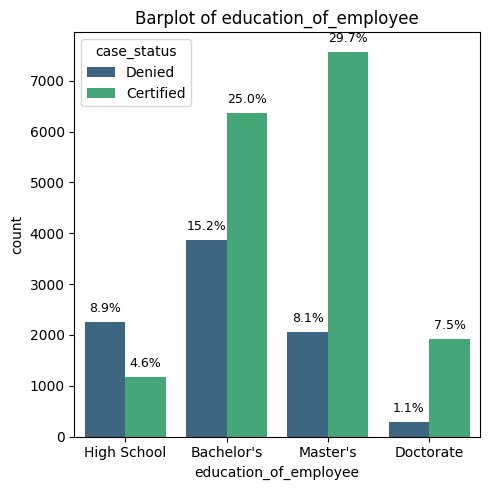

In [13]:
# Step 1: Group the dataset by 'education_of_employee' and count the number of each 'case_status'
# This gives a frequency table showing how case statuses are distributed across different education levels
education_case_counts = df.groupby('education_of_employee')['case_status'].value_counts()

# Optional: Display the grouped count table
print("Case status distribution by education level:")
print(education_case_counts)
print("-" * 80)

# Step 2: Create a labeled barplot to visualize the distribution
# This plot shows counts (or percentages) of case_status within each education level
# `order` ensures categories appear in logical educational hierarchy
labeled_barplot(
    data=df,
    feature='education_of_employee',
    feature_2='case_status',
    order=["High School", "Bachelor's", "Master's", "Doctorate"],
    perc=True  # Display percentages on the bars instead of absolute counts
)


In [14]:
#group data by continent and count the numbers of each case_status for each category
df.groupby('continent')['case_status'].value_counts()

continent      case_status
Africa         Certified        397
               Denied           154
Asia           Certified      11012
               Denied          5849
Europe         Certified       2957
               Denied           775
North America  Certified       2037
               Denied          1255
Oceania        Certified        122
               Denied            70
South America  Certified        493
               Denied           359
Name: count, dtype: int64

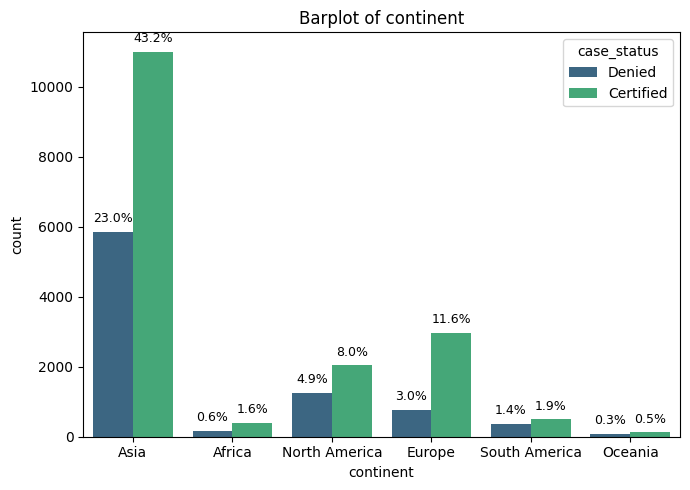

In [15]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df,'continent','case_status', order=None, perc=True)

In [16]:
#group data by has_job_experience and count the numbers of each case_status for each category
df.groupby('has_job_experience')['case_status'].value_counts()

has_job_experience  case_status
N                   Certified       5994
                    Denied          4684
Y                   Certified      11024
                    Denied          3778
Name: count, dtype: int64

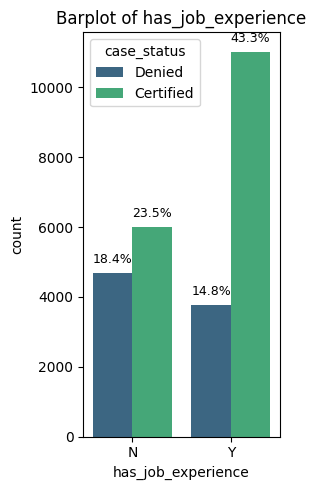

In [17]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df,'has_job_experience','case_status', order=None, perc=True)

In [18]:
#group data by unit_of_wage and count the numbers of each case_status for each category
df.groupby('unit_of_wage')['case_status'].value_counts()


unit_of_wage  case_status
Hour          Denied          1410
              Certified        747
Month         Certified         55
              Denied            34
Week          Certified        169
              Denied           103
Year          Certified      16047
              Denied          6915
Name: count, dtype: int64

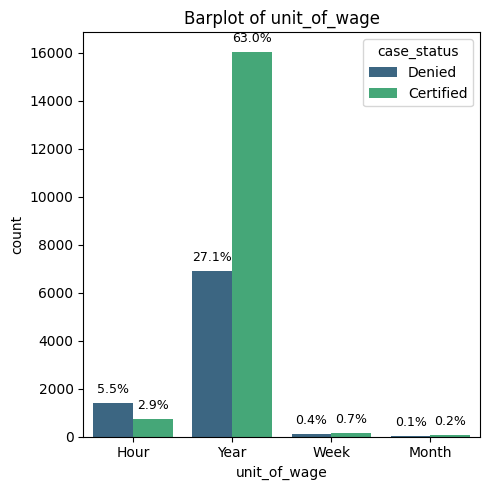

In [19]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df,'unit_of_wage','case_status', order=None, perc=True)

In [20]:
#group data by unit_of_wage and calculate the mean prevailing_wage for each category
df.groupby('unit_of_wage')['prevailing_wage'].mean()

unit_of_wage
Hour       414.570513
Month    87592.864045
Week     85606.820515
Year     81228.077133
Name: prevailing_wage, dtype: float64

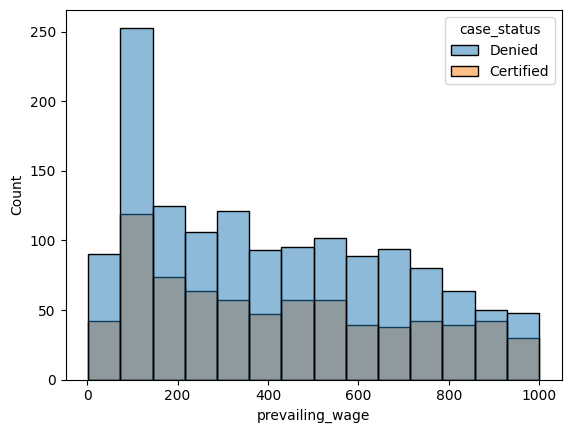

In [21]:
#create a dataframe only of workers applying for jobs with a *unit_wage* of 'Hour'
df_hourly = df[df.unit_of_wage=='Hour']
#show a distribution of the *prevailing_wage* within this dataframe, along with the ratio of *case_status* within each bin
sns.histplot(data=df_hourly, x='prevailing_wage', hue='case_status')
plt.show()

In [22]:
#create bins that categorize applicants by the per-day wage of the job he or she is applying for
bins = list(np.arange(0,1100,200))
#assign each applicant to a category
df_hourly['income_per_day'] = pd.cut(df_hourly['prevailing_wage'], bins)
df_hourly.groupby('income_per_day')['case_status'].value_counts()

income_per_day  case_status
(0, 200]        Denied         448
                Certified      219
(200, 400]      Denied         301
                Certified      166
(400, 600]      Denied         274
                Certified      144
(600, 800]      Denied         239
                Certified      116
(800, 1000]     Denied         148
                Certified      102
Name: count, dtype: int64

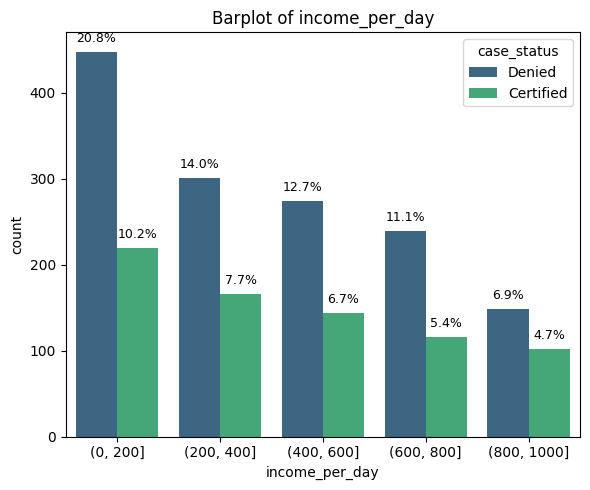

In [23]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df_hourly,'income_per_day','case_status',perc=True,order=None)

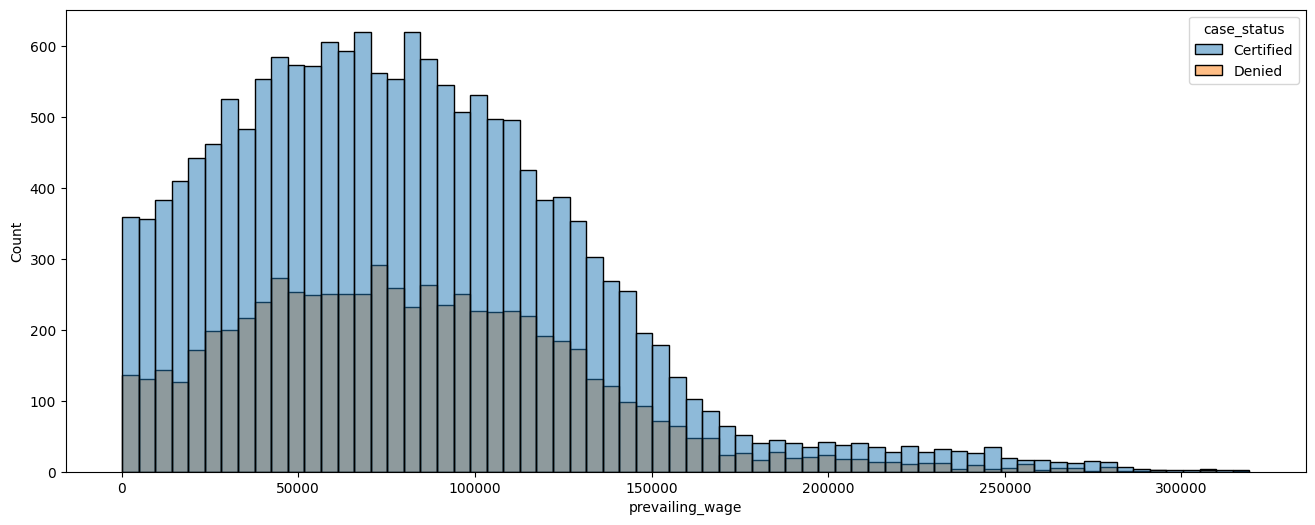

In [24]:
#create a new dataframe of only those applicants applying for jobs with annual salaries (i.e., not 'Hour')
df_annual = df[df.unit_of_wage != "Hour"]
#show the distribution of annual salaries, along with ratio of *case_status* within each bin
plt.figure(figsize=(16,6))
sns.histplot(data=df_annual, x='prevailing_wage', hue='case_status')
plt.show()

In [25]:
#create bins to categorize a job by its annual salary, which indicates how well paying the job is
bins = [0,25000,50000,75000,100000,125000,np.inf]
names = ['$0-25k','$25k-50k','$50k-75k','$75k-100k','$100k-125k','$125k+']
#assign an applicant to a category
df_annual['income_per_year'] = pd.cut(df_annual['prevailing_wage'], bins, labels=names)
df_annual.groupby('income_per_year')['case_status'].value_counts()

income_per_year  case_status
$0-25k           Certified      2090
                 Denied          761
$25k-50k         Certified      2839
                 Denied         1237
$50k-75k         Certified      3133
                 Denied         1372
$75k-100k        Certified      3014
                 Denied         1318
$100k-125k       Certified      2410
                 Denied         1138
$125k+           Certified      2785
                 Denied         1226
Name: count, dtype: int64

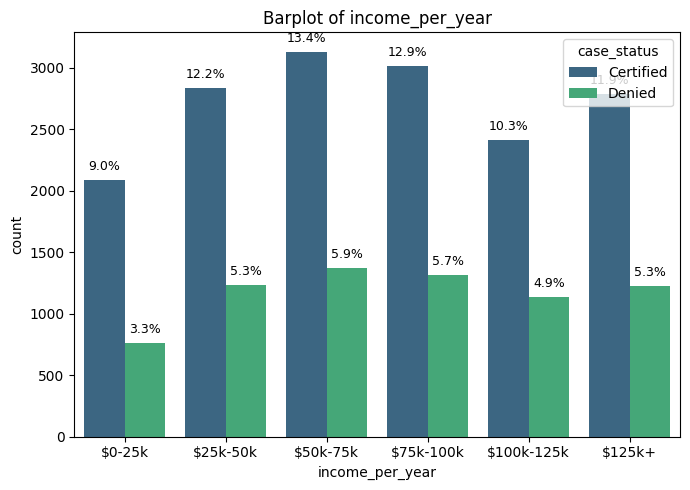

In [26]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df_annual,'income_per_year','case_status',perc=True,order=None)

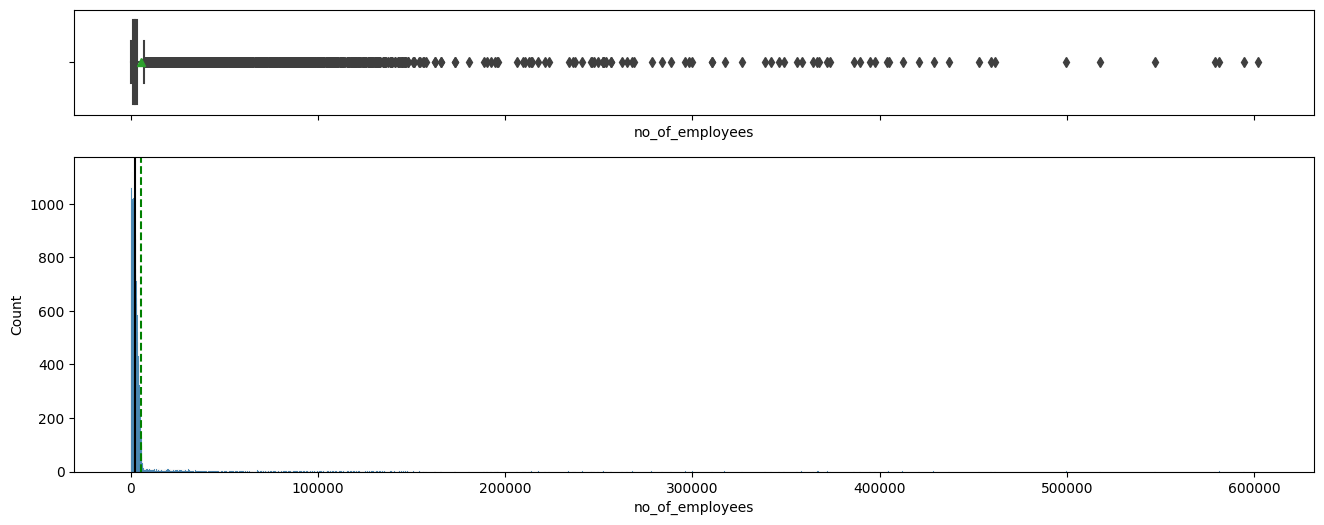

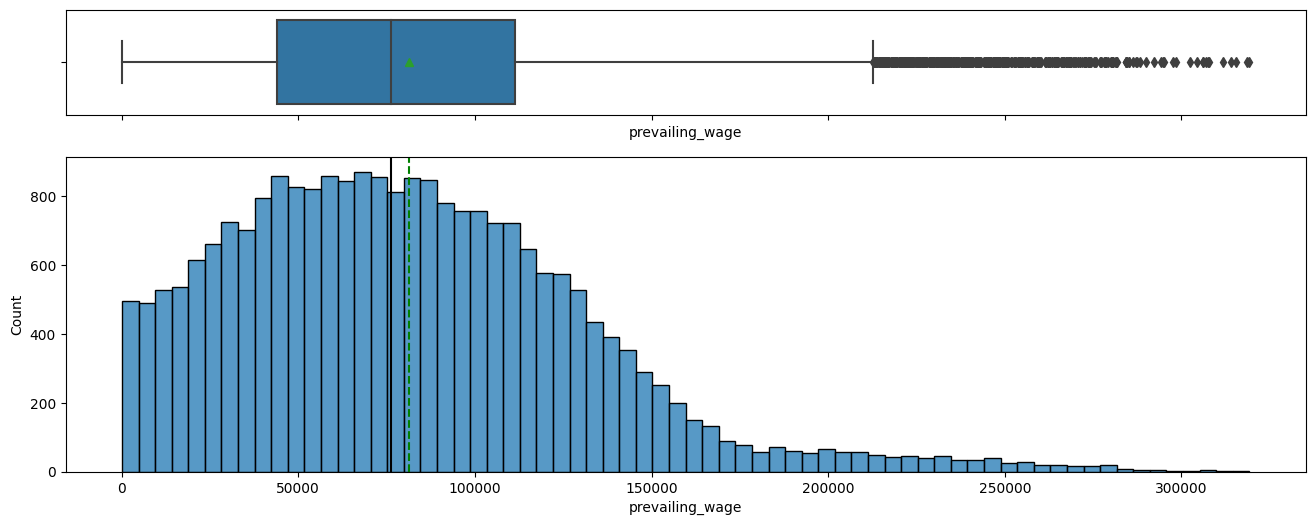

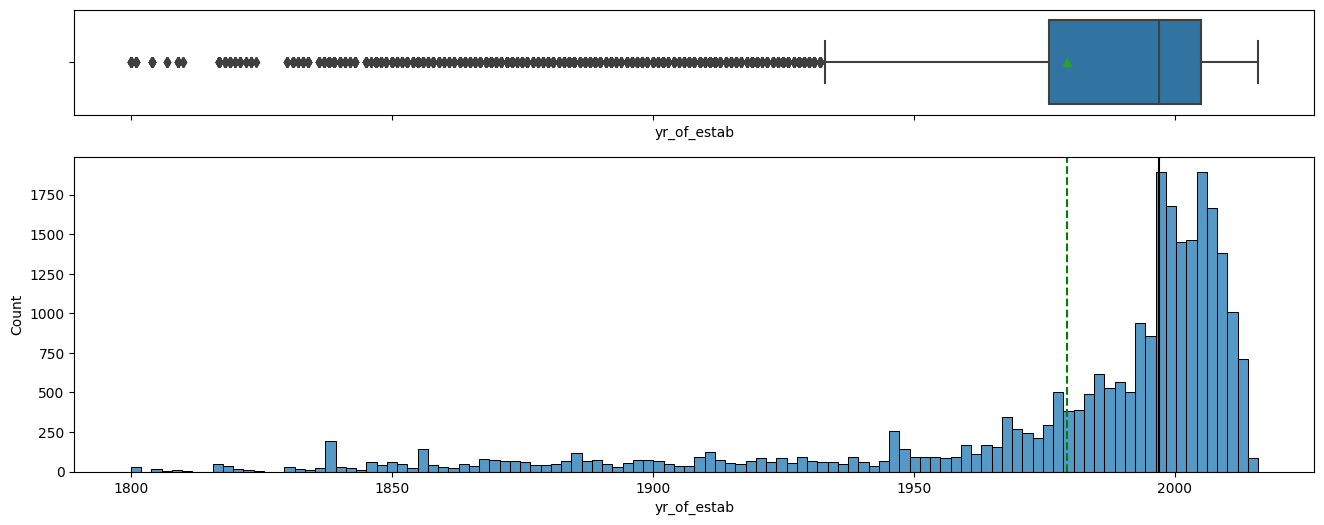

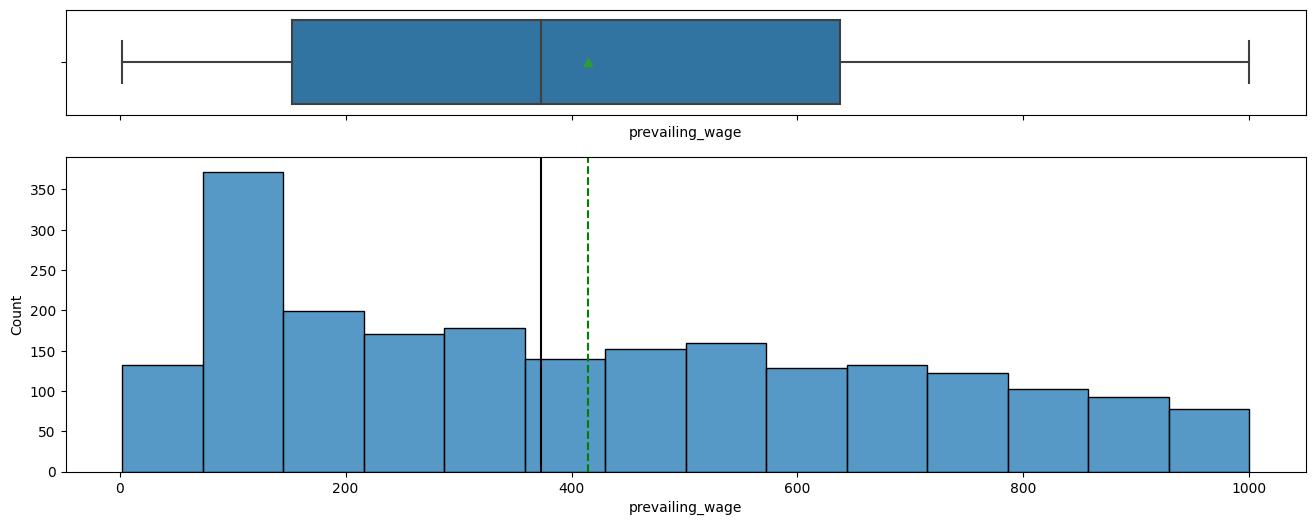

In [27]:
#provide histogram and boxplots
histogram_boxplot(df, 'no_of_employees')
histogram_boxplot(df_annual,'prevailing_wage')
histogram_boxplot(df, 'yr_of_estab')
histogram_boxplot(df_hourly,'prevailing_wage')

# Bivariate Analysis

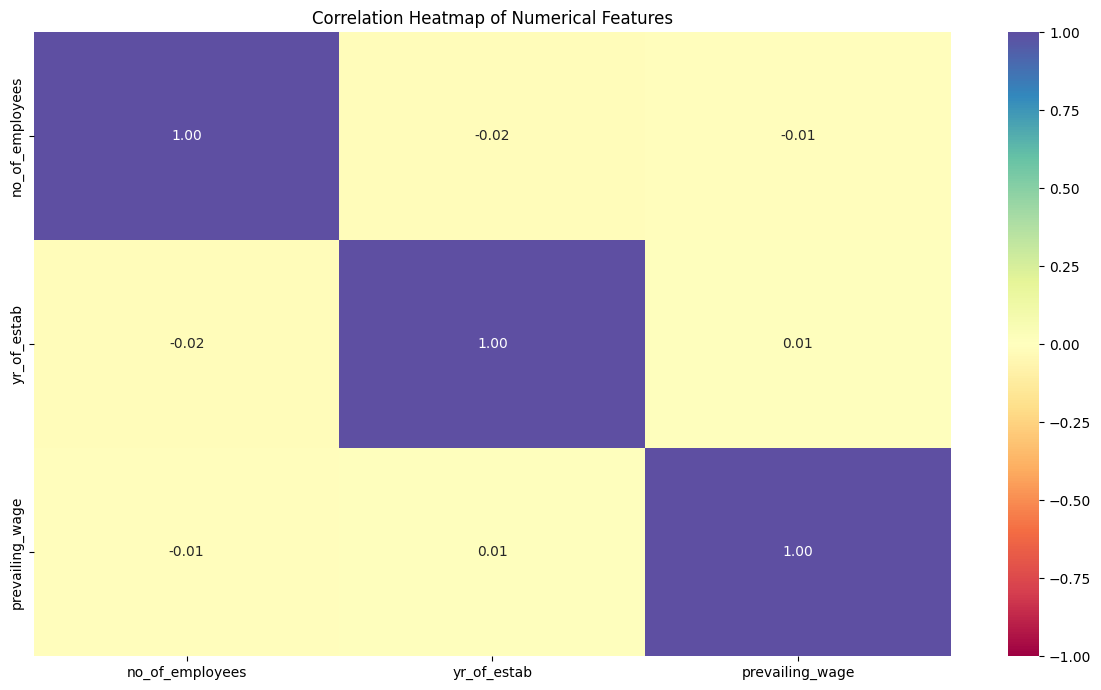

Skipping pair (education_of_employee, case_status): Predictor is not categorical or target missing.
Skipping pair (continent, case_status): Predictor is not categorical or target missing.
Skipping pair (region_of_employment, case_status): Predictor is not categorical or target missing.
Skipping pair (region_of_employment, education_of_employee): Predictor is not categorical or target missing.
Skipping pair (has_job_experience, case_status): Predictor is not categorical or target missing.
Skipping pair (unit_of_wage, case_status): Predictor is not categorical or target missing.
Skipping pair (has_job_experience, requires_job_training): Predictor is not categorical or target missing.


In [28]:

# Step 1: Create a correlation heatmap for all numerical features
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()  # Get list of numeric columns

plt.figure(figsize=(12, 7))
sns.heatmap(
    df[numeric_cols].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap="Spectral"
)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

# Step 2: Identify categorical columns for stacked bar plotting
categorical_cols = df.select_dtypes(include='category').columns.tolist()

# Step 3: Define a list of (predictor, target) column pairs for visualization
# Only create stacked plots where a categorical predictor makes sense with a categorical target
# This list can be dynamically extended if needed
column_pairs = [
    ('education_of_employee', 'case_status'),
    ('continent', 'case_status'),
    ('region_of_employment', 'case_status'),
    ('region_of_employment', 'education_of_employee'),
    ('has_job_experience', 'case_status'),
    ('unit_of_wage', 'case_status'),
    ('has_job_experience', 'requires_job_training')
]

# Step 4: Loop through each pair and create stacked barplots
for predictor, target in column_pairs:
    if predictor in categorical_cols and target in df.columns:
        print(f"\nGenerating stacked barplot for: {predictor} vs {target}")
        stacked_barplot(df, predictor, target)
    else:
        print(f"Skipping pair ({predictor}, {target}): Predictor is not categorical or target missing.")


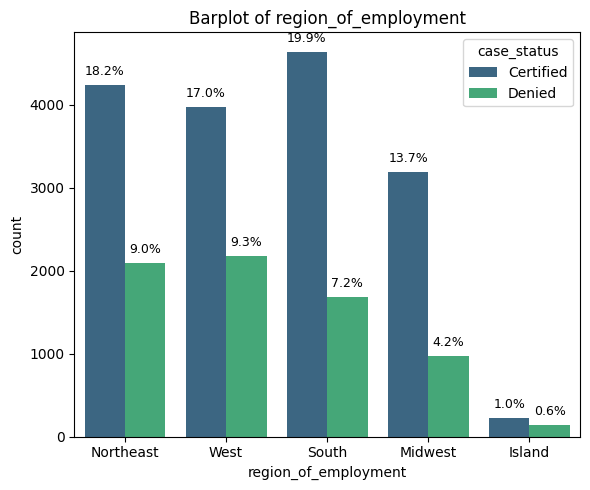

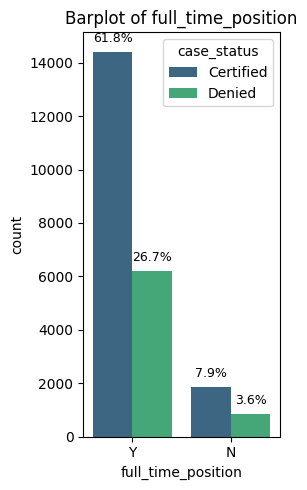

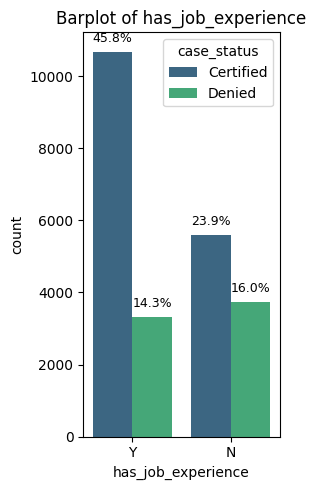

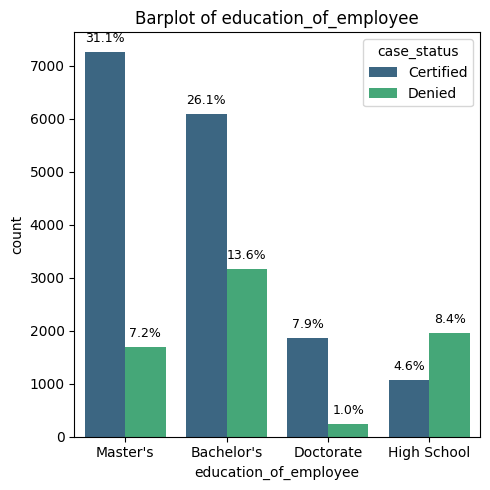

In [29]:
#create a barplot  for an applicant's job with the corresponding percent of approved and denied cases for each
labeled_barplot(df_annual,'region_of_employment','case_status',perc=True,order=None)
labeled_barplot(df_annual,'full_time_position','case_status',perc=True,order=None)
labeled_barplot(df_annual,'has_job_experience','case_status',perc=True,order=None)
labeled_barplot(df_annual,'education_of_employee','case_status',perc=True,order=None)

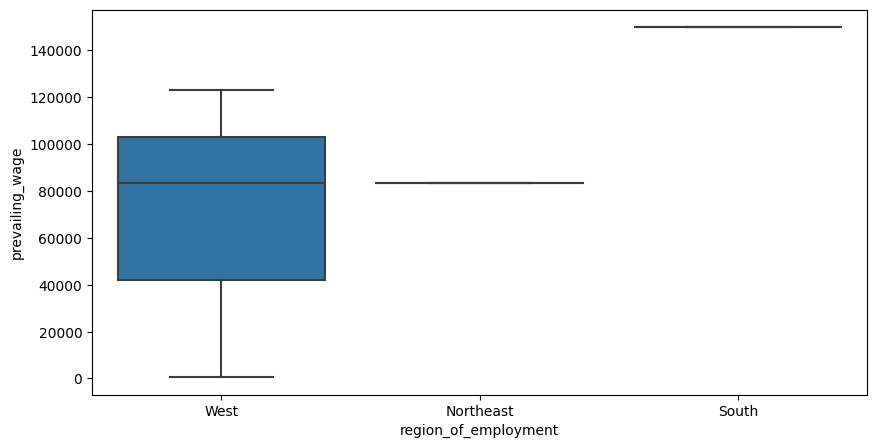

In [30]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x="region_of_employment", y="prevailing_wage")
plt.show()

In [31]:
#create tables listing the mean wage for each unique value within each variable with a data type category
for col in df_hourly.dtypes.index:
    print(f"Mean prevailing_wage grouped by '{col}':")
    print(df_hourly.groupby(col)['prevailing_wage'].mean())
    print("-" * 50)  # separator line

# print(df_hourly.groupby('continent')['prevailing_wage'].mean())
# print(df_hourly.groupby('education_of_employee')['prevailing_wage'].mean())

Mean prevailing_wage grouped by 'case_id':
case_id
EZYV01       592.2029
EZYV08       418.2298
EZYV10007      9.5331
EZYV1001     665.1571
EZYV10011    849.9988
               ...   
EZYV9955     572.1175
EZYV996       47.4872
EZYV9974     108.3100
EZYV9996     666.8553
EZYV9999     116.3800
Name: prevailing_wage, Length: 2157, dtype: float64
--------------------------------------------------
Mean prevailing_wage grouped by 'continent':
continent
Africa           399.125586
Asia             421.728375
Europe           398.228533
North America    406.187118
Oceania          477.197228
South America    392.165653
Name: prevailing_wage, dtype: float64
--------------------------------------------------
Mean prevailing_wage grouped by 'education_of_employee':
education_of_employee
Bachelor's     412.734576
Doctorate      414.554718
High School    418.064771
Master's       415.187066
Name: prevailing_wage, dtype: float64
--------------------------------------------------
Mean prevailing_wage

# Data Preprocessing

In [32]:
#to check outliers
def detect_outliers_boxplot(df, column):
    """
    Detect outliers in a column using boxplot.

    data: DataFrame
    column: Column name for which outliers need to be detected
    """
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data[column])
    plt.xlabel(column)
    plt.title(f'Boxplot for {column}')


    plt.show()

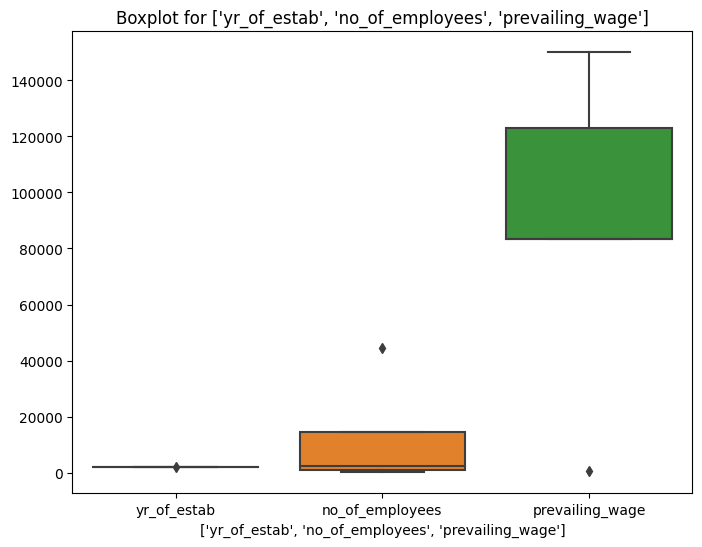

In [33]:
# List of numerical columns
numerical_columns2 = ['yr_of_estab', 'no_of_employees', 'prevailing_wage']

# Detect outliers using boxplots and the IQR method
detect_outliers_boxplot(df, numerical_columns2)

In [34]:

df_model = df.drop(labels=['no_of_employees','yr_of_estab'], axis=1, inplace=True)
df["case_status"] = df["case_status"].apply(lambda x: 1 if x == "Certified" else 0)
X = df.drop('case_status',axis=1)
#create a datafrane of the predicted class (1=True, 0=False)
Y = df['case_status']
#generate dummy variables for each categorical variable
X = pd.get_dummies(X, drop_first=True)
#create a dataframe of the predictor feature columns

#split the data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
#confirm the split
print("{0:0.2f}% data is in training set".format((len(x_train)/len(df.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(x_test)/len(df.index)) * 100))

70.00% data is in training set
30.00% data is in test set


In [35]:
#confirm the shape of both data sets and the ratio of classes is the same across both train and test datasets
print("Shape of Training set : ", x_train.shape)
print("Shape of test set : ", x_test.shape)
print(' ')
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print(' ')
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))



Shape of Training set :  (17836, 25498)
Shape of test set :  (7644, 25498)
 
Percentage of classes in training set:
case_status
1    0.663602
0    0.336398
Name: proportion, dtype: float64
 
Percentage of classes in test set:
case_status
1    0.677917
0    0.322083
Name: proportion, dtype: float64


# Model Building

### Bagging and Boosting models ###

In [36]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [37]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Decision Tree Model ###

In [38]:
dtree = DecisionTreeClassifier(criterion='gini', random_state=1, class_weight='balanced')

dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=1)

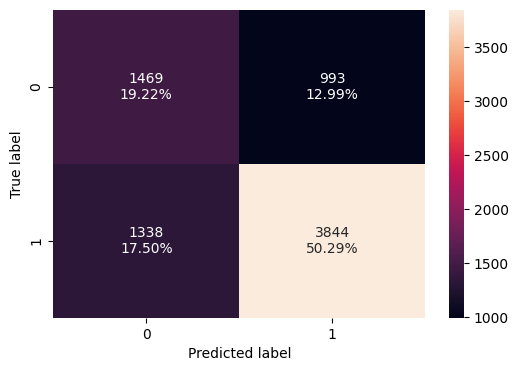

In [39]:
confusion_matrix_sklearn(dtree, x_test, y_test)

In [40]:
dtree_model_train_perf=model_performance_classification_sklearn(dtree, x_train, y_train)
print("Training performance \n",dtree_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [41]:
dtree_model_test_perf=model_performance_classification_sklearn(dtree, x_test, y_test)
print("Testing performance \n",dtree_model_test_perf)

Testing performance 
    Accuracy    Recall  Precision        F1
0  0.695055  0.741799   0.794707  0.767342


In [42]:
bagging = BaggingClassifier(random_state=1)
bagging.fit(x_train,y_train)

BaggingClassifier(random_state=1)

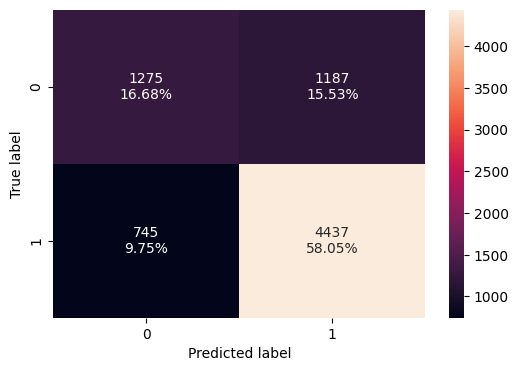

In [43]:
confusion_matrix_sklearn(bagging, x_test, y_test)

In [44]:
bagging_model_train_perf=model_performance_classification_sklearn(bagging, x_train, y_train)
print("Training performance \n",bagging_model_train_perf)
bagging_model_test_perf=model_performance_classification_sklearn(bagging, x_test, y_test)
print("Testing performance \n",bagging_model_test_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.970173  0.977442   0.977607  0.977524
Testing performance 
    Accuracy    Recall  Precision       F1
0  0.747253  0.856233    0.78894  0.82121


In [45]:
rf = RandomForestClassifier(random_state=1)
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=1)

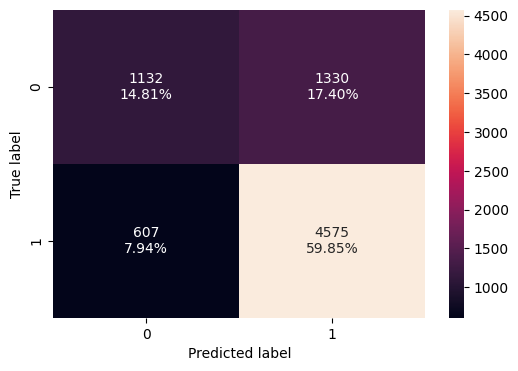

In [46]:
confusion_matrix_sklearn(rf,x_test,y_test)

In [47]:
rf_model_train_perf=model_performance_classification_sklearn(rf,x_train,y_train)
print("Training performance \n",rf_model_train_perf)
rf_model_test_perf=model_performance_classification_sklearn(rf,x_test,y_test)
print("Testing performance \n",rf_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance 
    Accuracy    Recall  Precision        F1
0  0.746599  0.882864   0.774767  0.825291


In [48]:
ab_classifier=AdaBoostClassifier(random_state=1)
ab_classifier.fit(x_train,y_train)

AdaBoostClassifier(random_state=1)

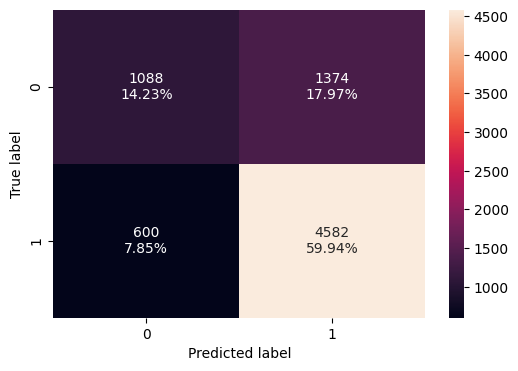

In [49]:
confusion_matrix_sklearn(ab_classifier, x_test,y_test)

In [50]:
ab_classifier_model_train_perf = model_performance_classification_sklearn(ab_classifier,x_train,y_train)
print("Training performance \n",ab_classifier_model_train_perf)
ab_classifier_model_test_perf = model_performance_classification_sklearn(ab_classifier,x_test,y_test)
print("Testing performance \n",ab_classifier_model_test_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.738114  0.883153   0.760716  0.817375
Testing performance 
    Accuracy    Recall  Precision        F1
0  0.741758  0.884215   0.769308  0.822769


In [51]:
xgb = XGBClassifier(random_state=1,eval_metric='logloss')
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

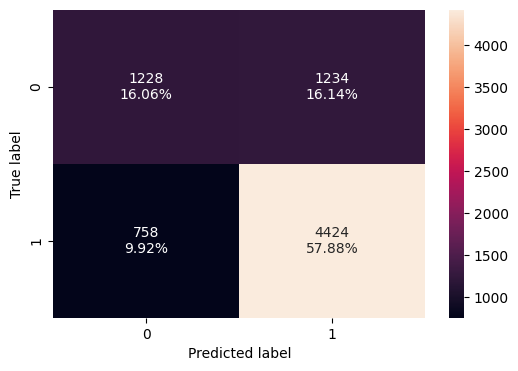

In [52]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(xgb, x_test,y_test)

In [53]:
xgb_classifier_model_train_perf = model_performance_classification_sklearn(xgb,x_train,y_train)
print("Training performance \n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf = model_performance_classification_sklearn(xgb,x_test,y_test)
print("Training performance \n",xgb_classifier_model_test_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.796984  0.899966   0.813813  0.854724
Training performance 
    Accuracy    Recall  Precision        F1
0  0.739403  0.853724   0.781902  0.816236


In [54]:
# create a dataframe comparing the performance of the base models on the training data

models_train_comp_df = pd.concat(
    [dtree_model_train_perf.T,
     bagging_model_train_perf.T,
     rf_model_train_perf.T,
     ab_classifier_model_train_perf.T,
     xgb_classifier_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Bagging Classifier",
    "Random Forest",
    "AdaBoost Classifier",
    "XGBoost Classifier"]
print("Training performance comparison of base models:")
models_train_comp_df

Training performance comparison of base models:


,Decision Tree,Bagging Classifier,Random Forest,AdaBoost Classifier,XGBoost Classifier
Accuracy,1.0,0.970173,1.0,0.738114,0.796984
Recall,1.0,0.977442,1.0,0.883153,0.899966
Precision,1.0,0.977607,1.0,0.760716,0.813813
F1,1.0,0.977524,1.0,0.817375,0.854724


In [55]:
# Step 1: Combine performance DataFrames from individual models
# Transpose each model's performance DataFrame (assuming metrics are rows, not columns)
# Then concatenate them side-by-side (axis=1) for comparison

models_test_comp_df = pd.concat(
    [
        dtree_model_test_perf.T,              # Decision Tree performance
        bagging_model_test_perf.T,            # Bagging Classifier performance
        rf_model_test_perf.T,                 # Random Forest performance
        ab_classifier_model_test_perf.T,      # AdaBoost performance
        xgb_classifier_model_test_perf.T      # XGBoost performance
    ],
    axis=1
)

# Step 2: Rename columns for clarity in the final comparison table
models_test_comp_df.columns = [
    "Decision Tree",
    "Bagging Classifier",
    "Random Forest",
    "AdaBoost Classifier",
    "XGBoost Classifier"
]

# Step 3: Print a clear label for the output and display the DataFrame
print("Testing performance comparison of base models:")
display(models_test_comp_df)  # using display() is better in Jupyter for full formatting


Testing performance comparison of base models:


,Decision Tree,Bagging Classifier,Random Forest,AdaBoost Classifier,XGBoost Classifier
Accuracy,0.695055,0.747253,0.746599,0.741758,0.739403
Recall,0.741799,0.856233,0.882864,0.884215,0.853724
Precision,0.794707,0.788940,0.774767,0.769308,0.781902
F1,0.767342,0.821210,0.825291,0.822769,0.816236


# Hyperparameter tuning

In [56]:

# Step 1: Initialize a Decision Tree classifier with class balancing
# Setting 'class_weight="balanced"' helps handle imbalanced datasets
# 'random_state=1' ensures reproducibility
dtree = DecisionTreeClassifier(class_weight="balanced", random_state=1)

# Step 2: Define the hyperparameter grid to search over
# These parameters help control model complexity and prevent overfitting
param_grid = {
    "max_depth": np.arange(10, 20, 5),                # Depth of tree (10, 15)
    "min_samples_leaf": [3, 5],                       # Minimum number of samples at leaf nodes
    "max_leaf_nodes": [2, 3, 5],                      # Maximum number of leaf nodes
    "min_impurity_decrease": [0.0001, 0.001],         # Minimum impurity decrease for node split
}

# Step 3: Define the evaluation metric for model selection
# F1-score is chosen as the scoring metric to balance precision and recall
f1_scorer = metrics.make_scorer(metrics.f1_score)

# Step 4: Set up GridSearchCV to perform hyperparameter tuning
# - Uses all available CPU cores (n_jobs=-1)
# - Evaluates combinations using f1-score
grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=1
)

# Step 5: Fit the grid search on the training data to find the best parameters
grid_search.fit(x_train, y_train)

# Step 6: Retrieve the best estimator from the grid search
dtree_estimator = grid_search.best_estimator_

# Step 7: Train the best model on the full training set
dtree_estimator.fit(x_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_leaf_nodes=2,
                       min_impurity_decrease=0.0001, min_samples_leaf=3,
                       random_state=1)

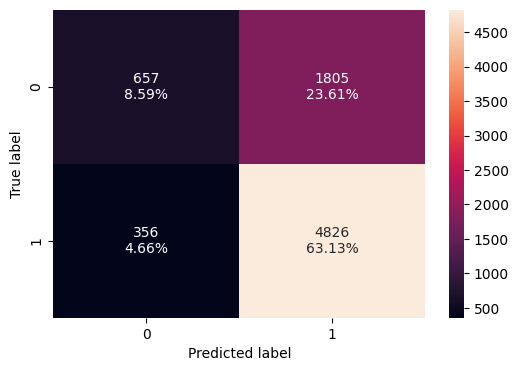

In [57]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(dtree_estimator, x_test,y_test)

In [58]:
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator, x_train,y_train)
print("Training performance \n",dtree_estimator_model_train_perf)
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator, x_test, y_test)
print("Testing performance \n",dtree_estimator_model_test_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0   0.70795  0.931734   0.714758  0.808949
Testing performance 
    Accuracy    Recall  Precision        F1
0  0.717295  0.931301   0.727794  0.817066


In [59]:
bagging_estimator = BaggingClassifier(random_state=1, n_jobs=-1)  # use all cores

# Step 2: Define a minimal parameter space for faster tuning
param_dist = {
    "max_samples": [0.8, 0.9],                # Subset of samples per base learner
    "max_features": [0.8, 0.9],               # Subset of features per learner
    "n_estimators": [10, 20]                  # Keep low for fast runs
}

# Step 3: Choose F1 score as the evaluation metric
f1_scorer = metrics.make_scorer(metrics.f1_score)

# Step 4: Run randomized search (extremely limited for speed)
rand_bag = RandomizedSearchCV(
    estimator=bagging_estimator,
    param_distributions=param_dist,
    n_iter=2,                  # Try only 2 random combinations
    scoring=f1_scorer,
    cv=2,                      # Only 2-fold CV
    n_jobs=-1,                 # Run all CV folds in parallel
    verbose=1
)

# Optional: Use a nominal subset of data for much faster search
x_small = x_train[:10000]
y_small = y_train[:10000]

# Step 5: Fit the model
rand_bag.fit(x_small, y_small)

# Step 6: Get best model and refit on the full or sample data
bag_tuned = rand_bag.best_estimator_
bag_tuned.fit(x_small, y_small)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=20, n_jobs=-1,
                  random_state=1)

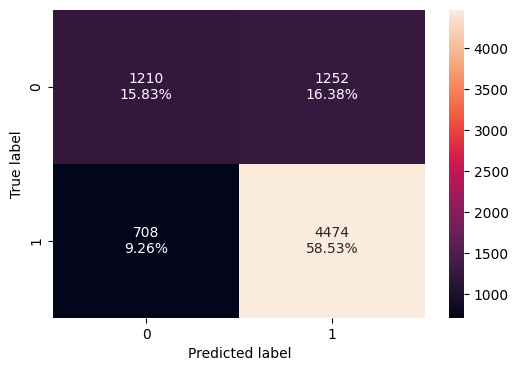

In [60]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(bag_tuned, x_test,y_test)

In [61]:
bagging_estimator_model_train_perf=model_performance_classification_sklearn(bag_tuned, x_train,y_train)
print("Training performance \n",bagging_estimator_model_train_perf)
bagging_estimator_model_test_perf=model_performance_classification_sklearn(bag_tuned, x_test, y_test)
print("Testing performance \n",bagging_estimator_model_test_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0     0.878  0.940014   0.883577  0.910922
Testing performance 
    Accuracy    Recall  Precision        F1
0   0.74359  0.863373   0.781348  0.820315


In [63]:
# Choose the type of classifier.
rf_estimator = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {"n_estimators": np.arange(10, 40, 10),
              "min_samples_leaf": np.arange(5, 10),
              "min_samples_split": [3, 5, 7],
              "max_features": ["sqrt", "log2"],
              "max_samples": np.arange(0.3, 0.7, 0.1),
}

# Run the randomized search
rand_rf = RandomizedSearchCV(rf_estimator, parameters, scoring='f1', cv=5, n_jobs=-1, random_state=1)
rand_rf = rand_rf.fit(x_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator = rand_rf.best_estimator_

# Fit the best algorithm to the data.
rf_estimator.fit(x_train, y_train)

RandomForestClassifier(max_features='log2', max_samples=0.4, min_samples_leaf=8,
                       min_samples_split=7, n_estimators=10, random_state=1)

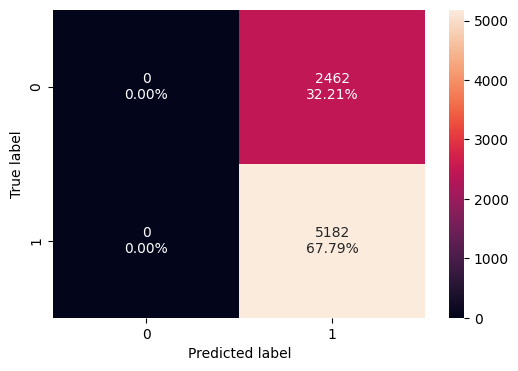

In [64]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(rf_estimator, x_test,y_test)

In [65]:
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator, x_train,y_train)
print("Training performance \n",rf_estimator_model_train_perf)
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator, x_test, y_test)
print("Testing performance \n",rf_estimator_model_test_perf)

Training performance 
    Accuracy  Recall  Precision        F1
0  0.663602     1.0   0.663602  0.797789
Testing performance 
    Accuracy  Recall  Precision        F1
0  0.677917     1.0   0.677917  0.808046


In [66]:
# Use a shallow base estimator for speed
fast_tree = DecisionTreeClassifier(max_depth=1)

abc_tuned = AdaBoostClassifier(estimator=fast_tree, random_state=1)

# Aggressively reduce parameter space
parameters = {
    "n_estimators": [10, 25, 50],          # Minimal number of trees
    "learning_rate": [0.1, 0.5, 1.0],      # Coarse values only
}

# F1 scorer (you can replace with precision, recall, or dummy scorer if needed)
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Use RandomizedSearch for speed
rand_abc = RandomizedSearchCV(
    abc_tuned,
    parameters,
    n_iter=4,                  # Only 4 combinations randomly sampled
    scoring=acc_scorer,
    cv=2,                      # Only 2-fold CV for speed
    n_jobs=-1,                 # Use all cores
    verbose=1
)

rand_abc.fit(x_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = rand_abc.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(x_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=10, random_state=1)

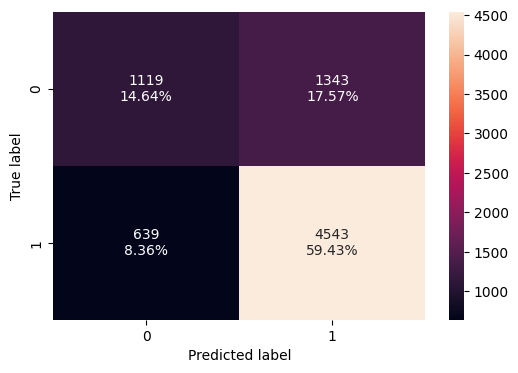

In [67]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(abc_tuned, x_test,y_test)

In [68]:
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned, x_train,y_train)
print("Training performance \n",abc_tuned_model_train_perf)
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned, x_test, y_test)
print("Testing performance \n",abc_tuned_model_test_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0   0.73688  0.877239   0.762167  0.815664
Testing performance 
    Accuracy    Recall  Precision        F1
0  0.740712  0.876689   0.771831  0.820925


In [69]:


# Fast, minimal XGB config
xgb_tuned = XGBClassifier(
    random_state=1,
    eval_metric='logloss',
    tree_method='hist',        # Fast CPU histogram method
    use_label_encoder=False,
    n_jobs=-1
)

# Minimal parameter space
parameters = {
    "n_estimators": [10, 50],         # Very small number of trees
    "learning_rate": [0.1, 1.0],      # Only two wide-spaced values
    "max_depth": [1, 2],              # Very shallow trees
}

# Use RandomizedSearch with only 2 iterations and 2-fold CV
grid_search = RandomizedSearchCV(
    estimator=xgb_tuned,
    param_distributions=parameters,
    n_iter=2,              # Only 2 combinations
    scoring='accuracy',    # Doesn't matter here
    cv=2,                  # Fast cross-validation
    n_jobs=-1,
    verbose=1
)

# Train on a small sample (EXTREME SPEEDUP)
x_small = x_train[:10000]
y_small = y_train[:10000]

grid_search.fit(x_small, y_small)

# Use best model (even if irrelevant for accuracy)
xgb_tuned = grid_search.best_estimator_

# Final fit on sample data
xgb_tuned.fit(x_small, y_small)


Fitting 2 folds for each of 2 candidates, totalling 4 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1.0, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=-1, num_parallel_tree=None, random_state=1, ...)

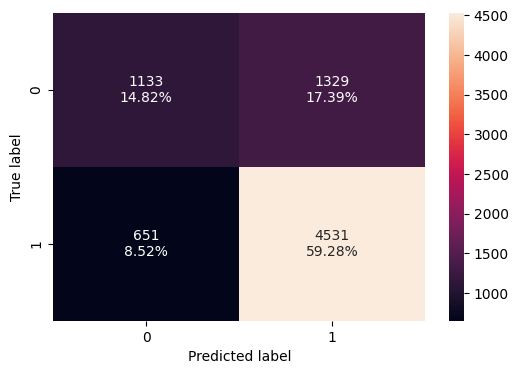

In [70]:
confusion_matrix_sklearn(xgb_tuned, x_test,y_test)

In [71]:
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned, x_train,y_train)
print("Training performance \n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned, x_test, y_test)
print("Testing performance \n",xgb_tuned_model_test_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.737665  0.875211   0.763882  0.815766
Testing performance 
    Accuracy    Recall  Precision        F1
0  0.740973  0.874373   0.773208  0.820685


# Tuned Models Comparison

In [72]:
# create a dataframe comparing the performance of the tuned models on the training data

tuned_models_train_comp_df = pd.concat(
    [dtree_estimator_model_train_perf.T,
     bagging_estimator_model_train_perf.T,
     rf_estimator_model_train_perf.T,
     abc_tuned_model_train_perf.T,
     xgb_tuned_model_train_perf.T],
    axis=1,
)
tuned_models_train_comp_df.columns = [
    "Tuned Decision Tree",
    "Tuned Bagging Classifier",
    "Tuned Random Forest",
    "Tuned AdaBoost Classifier",
    "Tuned XGBoost Classifier"]
print("Training performance comparison of tuned models:")
tuned_models_train_comp_df


Training performance comparison of tuned models:


,Tuned Decision Tree,Tuned Bagging Classifier,Tuned Random Forest,Tuned AdaBoost Classifier,Tuned XGBoost Classifier
Accuracy,0.707950,0.878000,0.663602,0.736880,0.737665
Recall,0.931734,0.940014,1.000000,0.877239,0.875211
Precision,0.714758,0.883577,0.663602,0.762167,0.763882
F1,0.808949,0.910922,0.797789,0.815664,0.815766


In [73]:
# create a dataframe comparing the performance of the tuned models on the testing data

tuned_models_test_comp_df = pd.concat(
    [dtree_estimator_model_test_perf.T,
     bagging_estimator_model_test_perf.T,
     rf_estimator_model_test_perf.T,
     abc_tuned_model_test_perf.T,
     xgb_tuned_model_test_perf.T],
    axis=1,
)
tuned_models_test_comp_df.columns = [
    "Tuned Decision Tree",
    "Tuned Bagging Classifier",
    "Tuned Random Forest",
    "Tuned AdaBoost Classifier",
    "Tuned XGBoost Classifier"]
print("Testing performance comparison of tuned models:")
tuned_models_test_comp_df

Testing performance comparison of tuned models:


,Tuned Decision Tree,Tuned Bagging Classifier,Tuned Random Forest,Tuned AdaBoost Classifier,Tuned XGBoost Classifier
Accuracy,0.717295,0.743590,0.677917,0.740712,0.740973
Recall,0.931301,0.863373,1.000000,0.876689,0.874373
Precision,0.727794,0.781348,0.677917,0.771831,0.773208
F1,0.817066,0.820315,0.808046,0.820925,0.820685


# Model Performance Comparison

In [74]:
# create a dataframe comparing the performance all models on the training data
all_models_train_comp = pd.concat([models_train_comp_df,tuned_models_train_comp_df],axis=1)
all_models_train_comp.T.sort_values('F1',ascending=False)

,Accuracy,Recall,Precision,F1
Decision Tree,1.000000,1.000000,1.000000,1.000000
Random Forest,1.000000,1.000000,1.000000,1.000000
Bagging Classifier,0.970173,0.977442,0.977607,0.977524
Tuned Bagging Classifier,0.878000,0.940014,0.883577,0.910922
XGBoost Classifier,0.796984,0.899966,0.813813,0.854724
AdaBoost Classifier,0.738114,0.883153,0.760716,0.817375
Tuned XGBoost Classifier,0.737665,0.875211,0.763882,0.815766
Tuned AdaBoost Classifier,0.736880,0.877239,0.762167,0.815664
Tuned Decision Tree,0.707950,0.931734,0.714758,0.808949
Tuned Random Forest,0.663602,1.000000,0.663602,0.797789


In [75]:
'The best performing model on the training data is the ' + all_models_train_comp.T.sort_values('F1',ascending=False).index[0]

'The best performing model on the training data is the Decision Tree'

In [76]:
# create a dataframe comparing the performance of all models on the testing data
all_models_test_comp = pd.concat([models_test_comp_df,tuned_models_test_comp_df],axis=1)
all_models_test_comp.T.sort_values('F1',ascending=False)

,Accuracy,Recall,Precision,F1
Random Forest,0.746599,0.882864,0.774767,0.825291
AdaBoost Classifier,0.741758,0.884215,0.769308,0.822769
Bagging Classifier,0.747253,0.856233,0.788940,0.821210
Tuned AdaBoost Classifier,0.740712,0.876689,0.771831,0.820925
Tuned XGBoost Classifier,0.740973,0.874373,0.773208,0.820685
Tuned Bagging Classifier,0.743590,0.863373,0.781348,0.820315
Tuned Decision Tree,0.717295,0.931301,0.727794,0.817066
XGBoost Classifier,0.739403,0.853724,0.781902,0.816236
Tuned Random Forest,0.677917,1.000000,0.677917,0.808046
Decision Tree,0.695055,0.741799,0.794707,0.767342


In [77]:
'The best performing model on the testing data is the ' + all_models_test_comp.T.sort_values('F1',ascending=False).index[0]

'The best performing model on the testing data is the Random Forest'

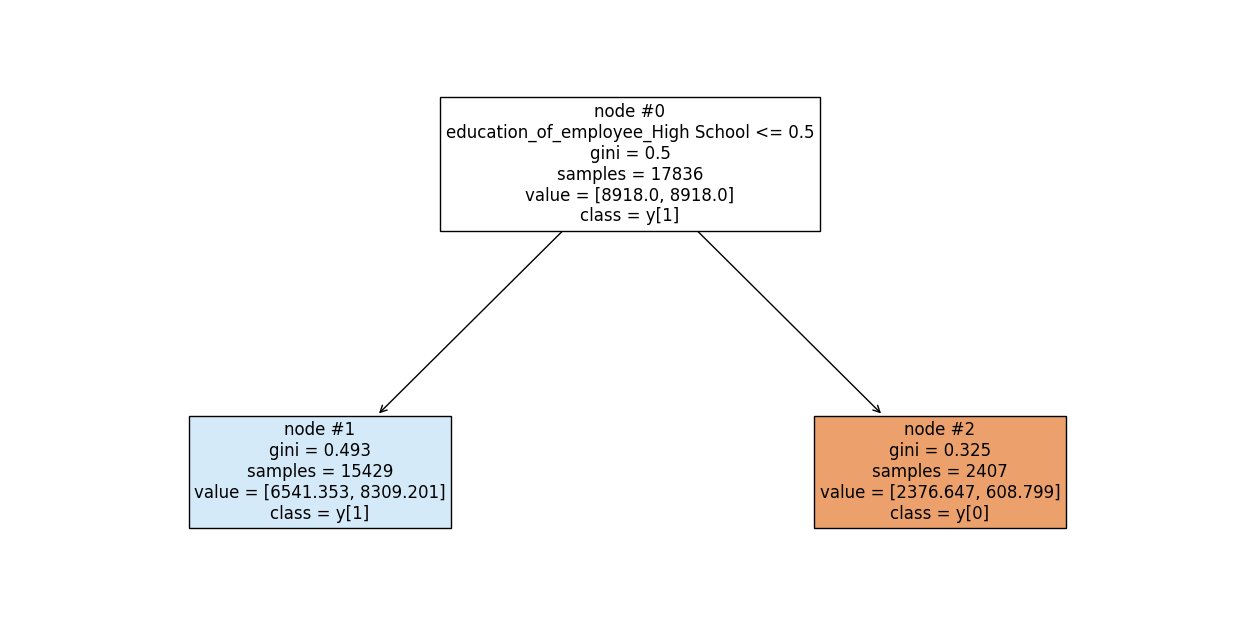

In [78]:
#create visualization of tuned decision-tree model
feature_names = list(X.columns)
plt.figure(figsize=(16,8))
tree.plot_tree(dtree_estimator,feature_names=feature_names,filled=True,fontsize=12,node_ids=True,class_names=True)
plt.show()
